## Instalación e importación de librerías, y definición de constantes

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 21.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

In [ ]:
# Importación de librerías
#import sentencepiece as spm
import io
import time
import numpy as np

from torch.utils.data import DataLoader
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from transformers import AutoTokenizer
from transformers import AutoModel
from sklearn.model_selection import train_test_split

import pandas as pd
from sklearn.utils import resample
from torch.utils.data import DataLoader, random_split

import re
from datasets import Dataset, DatasetDict

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, log_loss
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings("ignore")

# Configurar semillas para facilitar la reproducibilidad de los resultados
seed = 99
torch.manual_seed(seed)
np.random.seed(seed)

## 1. Tokenización

### 1.1. Carga de los datos

In [ ]:
# data = pd.read_excel('Datos_Totales.xlsx')
data = pd.read_excel("Data_final.xlsx")
print(data.shape)
# val_data = data[data['Dataset'] == 'val']
# data = data[data['Dataset'] == 'train-test']
print(data.shape)
# print(val_data.shape)

(11060, 5)
(11060, 5)


Veamos el contenido de los primeros 10 items del dataset:

In [ ]:
display(data[0:10])

,ID,Texto,Categoria,Categoría de 1 a 5,Dataset
0,1,"- ¡Rápido, necesitamos sangre! - Yo soy 0 posi...",Humor,4.0,test
1,2,- ¿Cuál es el mejor portero del mundial? - Ev...,Humor,3.0,train-val
2,3,El otro día unas chicas llamarón a mi puerta y...,Humor,3.0,test
3,4,"- Andresito, ¿qué planeta va después de Marte?...",Humor,4.0,train-val
4,5,- ¿Por qué Bob Esponja no va al gimnasio? - P...,Humor,1.0,train-val
5,6,Van dos ciegos y le dice uno al otro: - Ojalá...,Humor,2.0,test
6,7,Noticia de última hora!! Muere una suegra at...,Humor,4.0,test
7,8,"– Mamá, mamá, en el colegio dicen que estoy lo...",Humor,3.0,train-val
8,9,"– Mamá, mamá, ¿me haces un bocata de jamón? – ...",Humor,1.0,test
9,10,- Qué pasa si te expulsan de cuatro univerdade...,Humor,2.0,test


In [ ]:
print(data.shape)
data = data.drop_duplicates()
print(data.shape)

(11060, 5)
(11060, 5)


In [ ]:
def preprocessing(text):
  #text = re.sub(r'[^a-zA-Z\s]', '', text)
  text = re.sub(r'[.,]', '', text)
  # text = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚñÑüÜ\s]', '', text)
  text = text.lower()
  text = text.replace("\n", " ")
  return text

data["Texto"] = data["Texto"].apply(preprocessing)
display(data[0:10])

,ID,Texto,Categoria,Categoría de 1 a 5,Dataset
0,1,- ¡rápido necesitamos sangre! - yo soy 0 posit...,Humor,4.0,test
1,2,- ¿cuál es el mejor portero del mundial? - ev...,Humor,3.0,train-val
2,3,el otro día unas chicas llamarón a mi puerta y...,Humor,3.0,test
3,4,- andresito ¿qué planeta va después de marte? ...,Humor,4.0,train-val
4,5,- ¿por qué bob esponja no va al gimnasio? - p...,Humor,1.0,train-val
5,6,van dos ciegos y le dice uno al otro: - ojalá...,Humor,2.0,test
6,7,noticia de última hora!! muere una suegra at...,Humor,4.0,test
7,8,– mamá mamá en el colegio dicen que estoy loco...,Humor,3.0,train-val
8,9,– mamá mamá ¿me haces un bocata de jamón? – ¿y...,Humor,1.0,test
9,10,- qué pasa si te expulsan de cuatro univerdade...,Humor,2.0,test


Subdataset de 1000 - Comentar código para ejecutar con todo el dataset

In [ ]:
# humor = data[data["Categoria"] == "Humor"]
# no_humor = data[data["Categoria"] == "No Humor"]

# # Tomar 500 ejemplos de cada clase
# humor_sample = resample(humor, n_samples=500, random_state=42, replace=False)
# no_humor_sample = resample(no_humor, n_samples=500, random_state=42, replace=False)

# # Combinar y mezclar los datos
# data = pd.concat([humor_sample, no_humor_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
data.shape

(11060, 5)

Ajuste al formato de la librería datasets

In [ ]:
# Mapear categorías a números
label_map = {"Humor": 1, "No Humor": 0}
data["label"] = data["Categoria"].map(label_map)

# Seleccionar solo las columnas necesarias
data = data[["Texto", "label","Dataset"]].rename(columns={"Texto": "text"})  # Formato compatible con datasets

# Dividir en train (80%), validación (10%) y test (10%)
data_train = data[data['Dataset'] == 'train-val']
print(data_train.shape)
data_val = data[data['Dataset'] == 'test']
print(data_val.shape)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data_train["text"], data_train["label"], test_size=0.2, random_state=42, stratify=data_train["label"]
)

test_texts, test_labels,  = data_val["text"],data_val["label"]

# Convertir a DataFrames
train_df = pd.DataFrame({"text": train_texts, "label": train_labels})
val_df = pd.DataFrame({"text": val_texts, "label": val_labels})
test_df = pd.DataFrame({"text": test_texts, "label": test_labels})
###
### CREO QUE HAY CONFUCION ENTRE VAL Y TEST

(9060, 3)
(2000, 3)


In [ ]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

dataset = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset
})

# Ver estructura final
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 7248
    })
    validation: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 1812
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 2000
    })
})


### 1.2. Carga del tokenizador de dccuchile/albert-base-spanish

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("dccuchile/albert-base-spanish")

tokenizer_config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

#### 1.2.2 Ejemplo tokenización

In [ ]:
encoded_text = tokenizer('Tokenizing text is a core task in NLP')
encoded_text

{'input_ids': [2, 11389, 17, 131, 760, 21094, 1026, 16, 8814, 6128, 30963, 67, 45, 30932, 30938, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
tokens

['[CLS]',
 '▁tok',
 'en',
 'iz',
 'ing',
 '▁text',
 '▁is',
 '▁a',
 '▁core',
 '▁tas',
 'k',
 '▁in',
 '▁n',
 'l',
 'p',
 '[SEP]']

In [ ]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

### 1.3 Tokenización del dataset

In [ ]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/7248 [00:00<?, ? examples/s]

Map:   0%|          | 0/1812 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Revisamos las nuevas columnas con las que contamos

In [ ]:
dataset_encoded['train'].column_names

['text',
 'label',
 '__index_level_0__',
 'input_ids',
 'token_type_ids',
 'attention_mask']

In [ ]:
model_ckpt = "dccuchile/albert-base-spanish"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/47.8M [00:00<?, ?B/s]

Prueba tokenización

In [ ]:
text = "this is a test"
sample_inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {sample_inputs['input_ids'].size()}\n"
      f"Tokenized text: {tokenizer.convert_ids_to_tokens(sample_inputs['input_ids'][0])}")

Input tensor shape: torch.Size([1, 6])
Tokenized text: ['[CLS]', '▁this', '▁is', '▁a', '▁test', '[SEP]']


Prueba pasando el ejemplo tokenizado al modelo

In [ ]:
inputs = {k:v.to(device) for k,v in sample_inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
    print(outputs)

model.safetensors:   0%|          | 0.00/47.8M [00:00<?, ?B/s]

BaseModelOutputWithPooling(last_hidden_state=tensor([[[-0.5721,  0.6887, -0.1359,  ..., -0.0981, -0.3824,  0.4966],
         [-0.3033,  0.1307, -0.1177,  ..., -0.0401, -0.1036, -0.0584],
         [-0.2995, -0.0178, -0.7295,  ...,  0.2726, -0.2885,  0.2392],
         [-0.2675,  0.1058, -0.1181,  ...,  0.0625, -0.0730, -0.0728],
         [-0.4781,  0.0599, -0.2581,  ...,  0.1150, -0.2145,  0.0822],
         [-0.6072,  0.7436, -0.0968,  ...,  0.2467, -0.2765, -0.2110]]],
       device='cuda:0'), pooler_output=tensor([[ 1.6338e-01, -7.9520e-02,  1.9850e-01, -3.5774e-02, -1.3262e-01,
         -9.8460e-01, -2.3509e-02,  2.5780e-02,  1.3737e-01,  4.5852e-02,
          5.6338e-01,  9.9992e-01,  6.5541e-01,  1.0000e+00, -9.9895e-01,
         -3.0949e-01, -8.7328e-01, -2.8769e-01, -7.9529e-02,  5.6757e-01,
          3.4824e-01, -1.0000e+00, -9.9075e-01,  9.2444e-01,  9.4064e-01,
         -9.9994e-01,  3.0231e-01,  9.8878e-01,  6.0147e-02,  4.3683e-02,
         -1.6489e-01,  9.9967e-01,  1.3326e-

In [ ]:
outputs.last_hidden_state[:, 0].shape

torch.Size([1, 768])

Función que retorna solo el último estado oculto:

In [ ]:
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k, v in batch.items()
    if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    return {"hidden state": last_hidden_state[:, 0].cpu().numpy()}

### 1.4 Codificación del dataset

In [ ]:
dataset_encoded.set_format("torch", columns=['input_ids', 'attention_mask', 'label'])

In [ ]:
dataset_hidden = dataset_encoded.map(
    extract_hidden_states, batched=True, batch_size=8)

Map:   0%|          | 0/7248 [00:00<?, ? examples/s]

Map:   0%|          | 0/1812 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
dataset_hidden["train"].column_names

['text',
 'label',
 '__index_level_0__',
 'input_ids',
 'token_type_ids',
 'attention_mask',
 'hidden state']

In [ ]:
X_train = np.array(dataset_hidden["train"]["hidden state"])
X_valid = np.array(dataset_hidden["validation"]["hidden state"])
y_train = np.array(dataset_hidden["train"]["label"])
y_valid = np.array(dataset_hidden["validation"]["label"])
print(X_train.shape, X_valid.shape)

(7248, 768) (1812, 768)


## 2. Clasificación de los textos

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(25,), max_iter=1, warm_start=True, random_state=42)

train_losses = []
val_losses = []

# Entrenar manualmente por época
for epoch in range(50):
    clf.fit(X_train, y_train)

    # Predicciones
    y_train_prob = clf.predict_proba(X_train)
    y_val_prob = clf.predict_proba(X_valid)

    # Cálculo de log-loss
    train_losses.append(log_loss(y_train, y_train_prob))
    val_losses.append(log_loss(y_valid, y_val_prob))

y_pred = clf.predict(X_valid)
target_names = ['No Humor', 'Humor']
print(classification_report(y_valid, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    No Humor       0.94      0.97      0.96       849
       Humor       0.97      0.95      0.96       963

    accuracy                           0.96      1812
   macro avg       0.96      0.96      0.96      1812
weighted avg       0.96      0.96      0.96      1812



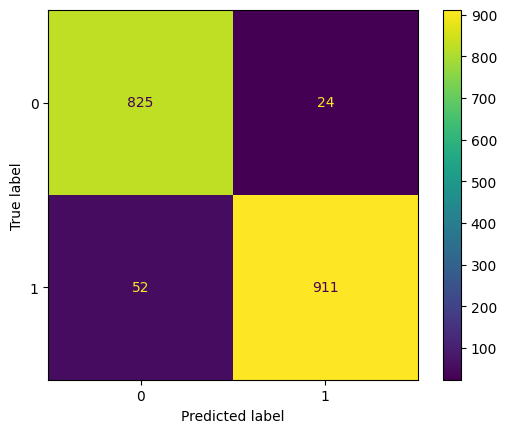

In [ ]:
cm = confusion_matrix(y_valid, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

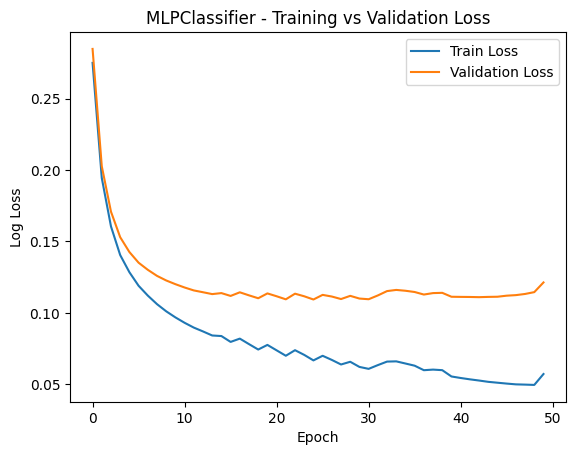

In [ ]:
# Graficar
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.title("MLPClassifier - Training vs Validation Loss")
plt.legend()
plt.show()

In [ ]:
print(val_losses[-1])
print(train_losses[-1])

0.1213164323708555
0.057186467910644155


              precision    recall  f1-score   support

    No Humor       0.89      0.97      0.93       804
       Humor       0.98      0.92      0.95      1196

    accuracy                           0.94      2000
   macro avg       0.93      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000



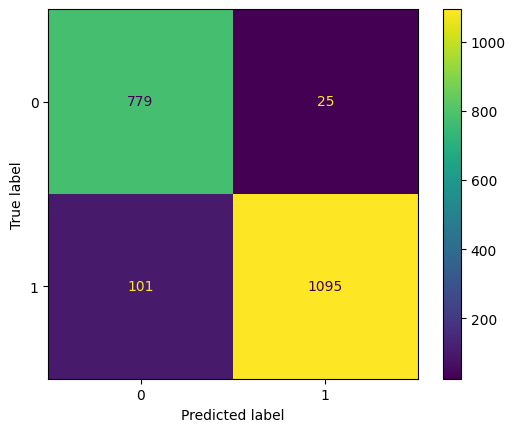

In [ ]:
# VALID
X_test = np.array(dataset_hidden["test"]["hidden state"])
y_test = np.array(dataset_hidden["test"]["label"])
y_test_pred = clf.predict(X_test)
target_names = ['No Humor', 'Humor']
print(classification_report(y_test, y_test_pred, target_names=target_names))
cm = confusion_matrix(y_test, y_test_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

## 3. Pruebas de estrés

In [ ]:
# Cargar el CSV (ajusta el nombre del archivo y el encoding si es necesario)
df_estres = pd.read_excel("/content/Plan de Trabajo Tesis.xlsx", sheet_name="Prueba_Estres")  # ejemplo: "datos.csv"

# Asegúrate de que las columnas se llamen como esperas; si no, cambia los nombres abajo
# Suponemos que la columna de texto se llama "texto" y la de categoría se llama "categoria"

# Convertir las categorías a binario
df_estres["categoria_binaria"] = df_estres["Label"].map({"No Humor": 0, "Humor": 1})

# Extraer listas
textos = df_estres["Texto"].tolist()
categorias = df_estres["categoria_binaria"].astype(str).tolist()
# textos = [
#     "Hombre pregunta mujer como va como casa",
#     "Pregunta mujer va",
#     "Ya nos encontramos en Lepe, una vez estemos alli",
#     """No sabes como necesito tu voz;
#     necesito tus miradas
#     aquellas palabras que siempre me llenaban,
#     necesito tu paz interior;
#     necesito la luz de tus labios
#     !!! Ya no puedo... seguir así !!!
#     ...Ya... No puedo""",
#     "Lionel Messi es un gran jugador jajaja",
#     "¿Por qué Bob Esponja no va al gimnasio? Porque ya está cuadrado."
# ]

# categorias = [
#     "0",
#     "0",
#     "0",
#     "0",
#     "0",
#     "1"
# ]

df_stress = pd.DataFrame({
    'text': textos,
    'label': categorias
})

St_dataset = Dataset.from_pandas(df_stress)

St_encoded = St_dataset.map(tokenize, batched=True, batch_size=None)
St_encoded.set_format("torch", columns=['input_ids', 'attention_mask', 'label'])

St_hidden = St_encoded.map(extract_hidden_states, batched=True, batch_size=8)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
St_hidden.column_names

['text',
 'label',
 'input_ids',
 'token_type_ids',
 'attention_mask',
 'hidden state']

In [ ]:
X_St = np.array(St_hidden["hidden state"])
Y_St = np.array(St_hidden["label"]).astype(int)

In [ ]:
y_pred_st = clf.predict(X_St)
y_pred_st

array([1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
print(classification_report(Y_St, y_pred_st, target_names=target_names))

              precision    recall  f1-score   support

    No Humor       0.61      0.56      0.58        50
       Humor       0.59      0.64      0.62        50

    accuracy                           0.60       100
   macro avg       0.60      0.60      0.60       100
weighted avg       0.60      0.60      0.60       100



## Prueba adicional utilizando Regresión logística para clasificación

In [ ]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(max_iter=3000, random_state=42)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000, random_state=42)

In [ ]:
y_pred = lr_clf.predict(X_St)
y_pred

array([1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
print("ACABO2")

ACABO2
